# Interactive Gaussian Splatting Viewer with Kaolin

This notebook provides an interactive viewer for Gaussian Splatting scenes using Kaolin's visualization tools.

## Requirements

Make sure you have installed:
```bash
pip install ipywidgets ipyevents ipycanvas jupyter matplotlib
pip install kaolin==0.15.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.0.0_cu118.html
```

## Features

- Interactive turntable viewer for Gaussian scenes
- Real-time rendering with Gaussian Splatting
- Filter Gaussians by scale, opacity, or other properties
- Supports any trained Gaussian Splatting model

## 1. Setup and Imports

In [1]:
import copy
import ipywidgets
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from pathlib import Path
from PIL import Image

try:
    import kaolin
    import kaolin.render.camera
    import kaolin.visualize
except ImportError:
    print("ERROR: Kaolin not installed. Please install with:")
    print("pip install kaolin==0.15.0 -f kaolin==0.17.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.0.1_cu118.html")
    raise

# Gaussian splatting dependencies
from utils.graphics_utils import focal2fov, getWorld2View2, getProjectionMatrix
from utils.system_utils import searchForMaxIteration
from utils.general_utils import PILtoTorch
from gaussian_renderer import render, GaussianModel
from scene.cameras import Camera as GSCamera

# Auto-reload for development
%load_ext autoreload
%autoreload 2
%matplotlib inline

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Warp 1.9.1 initialized:
   CUDA Toolkit 12.8, Driver 13.0
   Devices:
     "cpu"      : "Intel64 Family 6 Model 141 Stepping 1, GenuineIntel"
     "cuda:0"   : "NVIDIA GeForce RTX 3050 Ti Laptop GPU" (4 GiB, sm_86, mempool enabled)
   Kernel cache:
     \\?\C:\Users\sonth\AppData\Local\NVIDIA\warp\Cache\1.9.1
✅ All imports successful!
PyTorch version: 2.0.1+cu118
CUDA available: True
✅ All imports successful!
PyTorch version: 2.0.1+cu118
CUDA available: True


## 2. Utility Functions

In [7]:
class PipelineParamsNoparse:
    """Pipeline parameters without argparse."""
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False
        self.debug = False


def find_model_paths():
    """Find all available trained models."""
    possible_dirs = ['output', 'data']
    found_models = []
    
    for base_dir in possible_dirs:
        if not os.path.exists(base_dir):
            continue
        for item in os.listdir(base_dir):
            item_path = os.path.join(base_dir, item)
            if os.path.isdir(item_path):
                point_cloud_dir = os.path.join(item_path, 'point_cloud')
                if os.path.exists(point_cloud_dir):
                    found_models.append(item_path)
    
    return found_models


def load_checkpoint(model_path, sh_degree=3, iteration=-1):
    """
    Load a Gaussian Splatting checkpoint.
    
    Args:
        model_path: Path to model directory
        sh_degree: Spherical harmonics degree (default: 3)
        iteration: Iteration to load (-1 for latest)
    
    Returns:
        GaussianModel with loaded parameters
    """
    checkpt_dir = os.path.join(model_path, "point_cloud")
    
    if not os.path.exists(checkpt_dir):
        raise FileNotFoundError(f"Checkpoint directory not found: {checkpt_dir}")
    
    if iteration == -1:
        iteration = searchForMaxIteration(checkpt_dir)
        print(f"Auto-detected iteration: {iteration}")
    
    checkpt_path = os.path.join(checkpt_dir, f"iteration_{iteration}", "point_cloud.ply")
    # checkpt_path = 'data/stone_gravel_patch/point_cloud.ply'

    if not os.path.exists(checkpt_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpt_path}")
    
    print(f"Loading checkpoint: {checkpt_path}")
    gaussians = GaussianModel(sh_degree)
    gaussians.load_ply(checkpt_path)
    
    print(f"✅ Loaded {len(gaussians.get_xyz)} Gaussians")
    return gaussians


def create_simple_camera(width=800, height=800, fovx=0.69, fovy=0.69):
    """
    Create a simple camera for rendering.
    
    Args:
        width: Image width
        height: Image height
        fovx: Horizontal field of view
        fovy: Vertical field of view
    
    Returns:
        GSCamera object
    """
    # Default camera looking at origin from +Z
    R = np.array([
        [-0.99037, 0.02331, -0.13640],
        [0.13838, 0.16679, -0.97623],
        [-0.00000, -0.98571, -0.16841]
    ])
    T = np.array([0.0, 0.0, 4.0])
    
    # Create dummy image for Camera class
    dummy_image = Image.new('RGB', (width, height), color=(0, 0, 0))
    
    camera = GSCamera(
        resolution=(width, height),
        colmap_id=0,
        R=R,
        T=T,
        FoVx=fovx,
        FoVy=fovy,
        depth_params=None,
        image=dummy_image,
        invdepthmap=None,
        image_name='viewer_cam',
        uid=0
    )
    
    return camera


print("✅ Utility functions defined")

✅ Utility functions defined


## 3. Camera Conversion Functions

Convert between Gaussian Splatting cameras and Kaolin cameras.

In [8]:
def compute_cam_fov(intrinsics, axis='x'):
    """
    Compute FOV from Kaolin camera intrinsics.
    
    Args:
        intrinsics: Kaolin camera intrinsics
        axis: 'x' or 'y' for horizontal or vertical FOV
    
    Returns:
        FOV in radians
    """
    aspectScale = intrinsics.width / 2.0
    tanHalfAngle = aspectScale / (intrinsics.focal_x if axis == 'x' else intrinsics.focal_y).item()
    fov = np.arctan(tanHalfAngle) * 2
    return fov


def convert_kaolin_to_gs_camera(kal_camera, width=512, height=512):
    """
    Convert Kaolin camera to Gaussian Splatting camera.
    
    Args:
        kal_camera: Kaolin Camera object
        width: Image width
        height: Image height
    
    Returns:
        GSCamera object
    """
    R = kal_camera.extrinsics.R[0].clone()
    R[1:3] = -R[1:3]
    T = kal_camera.extrinsics.t.squeeze().clone()
    T[1:3] = -T[1:3]
    
    # Create dummy image
    dummy_image = Image.new('RGB', (width, height), color=(0, 0, 0))
    
    camera = GSCamera(
        resolution=(width, height),
        colmap_id=0,
        R=R.transpose(1, 0).cpu().numpy(),
        T=T.cpu().numpy(),
        FoVx=compute_cam_fov(kal_camera.intrinsics, 'x'),
        FoVy=compute_cam_fov(kal_camera.intrinsics, 'y'),
        depth_params=None,
        image=dummy_image,
        invdepthmap=None,
        image_name='kaolin_cam',
        uid=0
    )
    
    return camera


def convert_gs_to_kaolin_camera(gs_camera):
    """
    Convert Gaussian Splatting camera to Kaolin camera.
    
    Args:
        gs_camera: GSCamera object
    
    Returns:
        Kaolin Camera object
    """
    view_mat = gs_camera.world_view_transform.transpose(1, 0).clone()
    view_mat[1:3] = -view_mat[1:3]
    
    kal_cam = kaolin.render.camera.Camera.from_args(
        view_matrix=view_mat,
        width=gs_camera.image_width,
        height=gs_camera.image_height,
        fov=gs_camera.FoVx,
        device='cpu'
    )
    
    return kal_cam


print("✅ Camera conversion functions defined")

✅ Camera conversion functions defined


## 4. Load Model

Choose a model to visualize. Update `model_path` to point to your trained model.

In [10]:
# Find available models
print("Searching for trained models...")
available_models = find_model_paths()

if available_models:
    print(f"\nFound {len(available_models)} trained model(s):")
    for i, model in enumerate(available_models):
        print(f"  [{i}] {model}")
    print("\nUpdate model_path below to one of these paths.")
else:
    print("\n⚠️  No trained models found!")
    print("Please train a model first with: python train.py -s <data_path>")

# DEFINE MODEL PATH HERE
model_path = available_models[0] if available_models else 'output/your_scene'
# model_path = 'data/stone_gravel_patch'
print(f"\nUsing model: {model_path}")

# Load the model
try:
    gaussians = load_checkpoint(model_path, sh_degree=3, iteration=-1)
    pipeline = PipelineParamsNoparse()
    background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
    print("\n✅ Model loaded successfully!")
except Exception as e:
    print(f"\n❌ Failed to load model: {e}")
    print("Please update model_path to a valid trained model directory.")
    raise

Searching for trained models...

Found 1 trained model(s):
  [0] data\train

Update model_path below to one of these paths.

Using model: data\train
Auto-detected iteration: 30000
Loading checkpoint: data/stone_gravel_patch/point_cloud.ply
✅ Loaded 429459 Gaussians

✅ Model loaded successfully!
✅ Loaded 429459 Gaussians

✅ Model loaded successfully!


## 5. Test Rendering

Test that rendering works correctly.

Rendering test image...


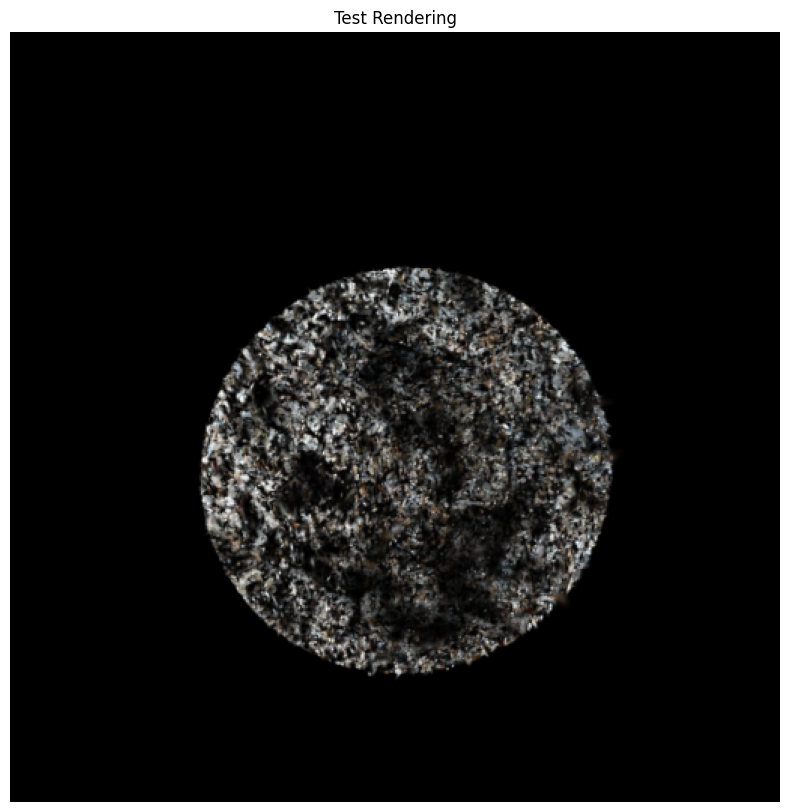


✅ Rendering test successful!
Rendered image shape: (512, 512, 3)
Number of Gaussians: 429459


In [11]:
# Create a test camera
test_camera = create_simple_camera(width=512, height=512)

# Render a test image
print("Rendering test image...")
with torch.no_grad():
    render_res = render(test_camera, gaussians, pipeline, background)
    rendering = render_res["render"]

# Display
img_np = (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(img_np)
plt.title("Test Rendering")
plt.axis('off')
plt.show()

print("\n✅ Rendering test successful!")
print(f"Rendered image shape: {img_np.shape}")
print(f"Number of Gaussians: {len(gaussians.get_xyz)}")

## 5.1 Depth Visualization

Visualize the depth map from the test rendering.

Depth map shape: torch.Size([1, 512, 512])
Depth range: 4.3938 to 15.0000


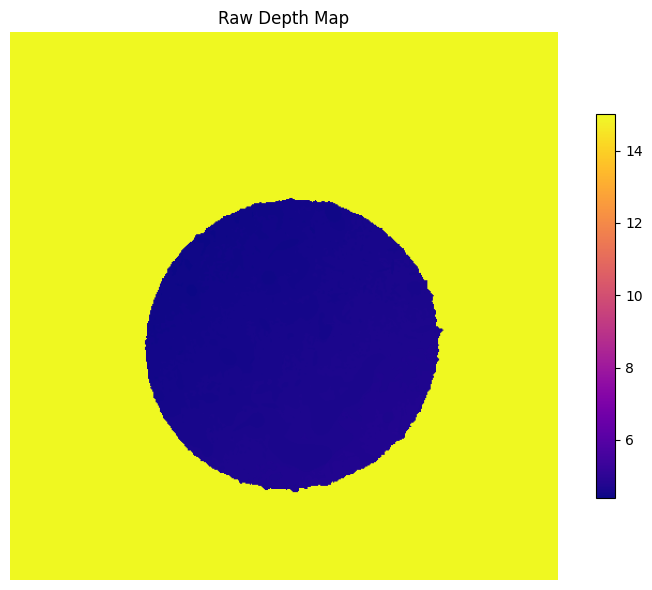

✅ Depth visualization complete!
Near objects appear in yellow/bright colors, far objects in blue/dark colors


In [12]:
# Visualize depth map from the test rendering
if 'render_res' in locals() and 'depth' in render_res:
    depth = render_res["depth"]
    print(f"Depth map shape: {depth.shape}")
    print(f"Depth range: {depth.min().item():.4f} to {depth.max().item():.4f}")
    
    # Convert depth to numpy for visualization and squeeze batch dimension
    depth_np = depth.detach().cpu().numpy()
    if depth_np.ndim == 3 and depth_np.shape[0] == 1:
        depth_np = depth_np.squeeze(0)  # Remove batch dimension
    
    # Create visualization
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    
    # Raw depth map only
    im1 = axes.imshow(depth_np, cmap='plasma')
    axes.set_title("Raw Depth Map")
    axes.axis('off')
    plt.colorbar(im1, ax=axes, shrink=0.7)
    
    # Commented out normalized depth map
    # depth_norm = (depth_np - depth_np.min()) / (depth_np.max() - depth_np.min())
    # im2 = axes[1].imshow(depth_norm, cmap='viridis')
    # axes[1].set_title("Normalized Depth Map")
    # axes[1].axis('off')
    # plt.colorbar(im2, ax=axes[1], shrink=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Depth visualization complete!")
    print("Near objects appear in yellow/bright colors, far objects in blue/dark colors")
else:
    print("❌ No depth data available. Make sure the test rendering cell above was run successfully.")

## 6. Interactive Kaolin Viewer

Launch the interactive turntable viewer.

In [13]:
def render_kaolin(kaolin_cam):
    """
    Render function for Kaolin visualizer.
    
    Args:
        kaolin_cam: Kaolin Camera object
    
    Returns:
        Rendered image as uint8 tensor
    """
    gs_cam = convert_kaolin_to_gs_camera(kaolin_cam, width=512, height=512)
    
    with torch.no_grad():
        render_res = render(gs_cam, gaussians, pipeline, background)
        rendering = render_res["render"]
    
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()


# Convert test camera to Kaolin format
kal_cam = convert_gs_to_kaolin_camera(test_camera)

# Calculate focus point (center of Gaussians)
xyz = gaussians.get_xyz.detach().cpu().numpy()
scene_center = torch.tensor(xyz.mean(axis=0), dtype=torch.float32)
focus_at = scene_center

print(f"Scene center: {scene_center.numpy()}")
print(f"Scene bounds: min={xyz.min(axis=0)}, max={xyz.max(axis=0)}")

# Create interactive visualizer
print("\nLaunching Kaolin interactive viewer...")
print("Use mouse to rotate, zoom, and pan the view.")

visualizer = kaolin.visualize.IpyTurntableVisualizer(
    512, 512,
    copy.deepcopy(kal_cam),
    render_kaolin,
    focus_at=focus_at,
    world_up_axis=1,  # Y-up
    max_fps=30
)

visualizer.show()

Scene center: [-0.0986477  -0.55493534 -0.37299266]
Scene bounds: min=[-1.0211458  -0.64977753 -1.2322586 ], max=[ 0.73798686 -0.41015866  0.52655065]

Launching Kaolin interactive viewer...
Use mouse to rotate, zoom, and pan the view.


Canvas(height=512, width=512)

Output()

## 7. Advanced: Selective Rendering with Filters

Add interactive controls to filter Gaussians by various properties.

In [8]:
# Analyze Gaussian properties
print("Analyzing Gaussian properties...")
scales = gaussians.get_scaling.detach().cpu()
opacities = gaussians.get_opacity.detach().cpu()

max_scale = scales.max(dim=1)[0]

print(f"\nScale statistics:")
print(f"  Min: {max_scale.min().item():.6f}")
print(f"  Max: {max_scale.max().item():.6f}")
print(f"  Mean: {max_scale.mean().item():.6f}")
print(f"  Median: {max_scale.median().item():.6f}")

print(f"\nOpacity statistics:")
print(f"  Min: {opacities.min().item():.6f}")
print(f"  Max: {opacities.max().item():.6f}")
print(f"  Mean: {opacities.mean().item():.6f}")
print(f"  Median: {opacities.median().item():.6f}")


def selective_render_kaolin(kaolin_cam):
    """
    Render with filtered Gaussians based on slider values.
    """
    # Filter by scale
    scaling = gaussians._scaling.max(dim=1)[0]
    mask = scaling < scale_slider.value
    
    # Filter by opacity
    opacity_mask = gaussians._opacity.squeeze() > opacity_slider.value
    mask = mask & opacity_mask
    
    # Create filtered Gaussian model
    tmp_gaussians = GaussianModel(gaussians.max_sh_degree)
    tmp_gaussians._xyz = gaussians._xyz[mask, :]
    tmp_gaussians._features_dc = gaussians._features_dc[mask, ...]
    tmp_gaussians._features_rest = gaussians._features_rest[mask, ...]
    tmp_gaussians._opacity = gaussians._opacity[mask, ...]
    tmp_gaussians._scaling = gaussians._scaling[mask, ...]
    tmp_gaussians._rotation = gaussians._rotation[mask, ...]
    tmp_gaussians.active_sh_degree = gaussians.max_sh_degree
    
    # Render
    gs_cam = convert_kaolin_to_gs_camera(kaolin_cam, width=512, height=512)
    
    with torch.no_grad():
        render_res = render(gs_cam, tmp_gaussians, pipeline, background)
        rendering = render_res["render"]
    
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()


def handle_slider_change(change):
    """Update visualization when sliders change."""
    visualizer2.out.clear_output()
    with visualizer2.out:
        visualizer2.render_update()
        n_gaussians = ((gaussians._scaling.max(dim=1)[0] < scale_slider.value) & 
                      (gaussians._opacity.squeeze() > opacity_slider.value)).sum().item()
        print(f"Rendering {n_gaussians}/{len(gaussians.get_xyz)} Gaussians")


# Create sliders
scale_slider = ipywidgets.FloatSlider(
    value=max_scale.max().item(),
    min=max_scale.min().item(),
    max=max_scale.max().item(),
    step=0.001,
    description='Max Scale:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.4f'
)

opacity_slider = ipywidgets.FloatSlider(
    value=-5.0,  # inverse_sigmoid space
    min=-10.0,
    max=5.0,
    step=0.1,
    description='Min Opacity:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)

scale_slider.observe(handle_slider_change, names='value')
opacity_slider.observe(handle_slider_change, names='value')

# Create visualizer with selective rendering
visualizer2 = kaolin.visualize.IpyTurntableVisualizer(
    512, 512,
    copy.deepcopy(kal_cam),
    selective_render_kaolin,
    focus_at=focus_at,
    world_up_axis=1,
    max_fps=30
)

# Display
print("\n🎮 Interactive viewer with filters:")
print("Adjust sliders to filter Gaussians by scale and opacity.")
visualizer2.render_update()
display(visualizer2.canvas, visualizer2.out, scale_slider, opacity_slider)

Analyzing Gaussian properties...

Scale statistics:
  Min: 0.000052
  Max: 10.242308
  Mean: 0.041560
  Median: 0.018656

Opacity statistics:
  Min: 0.000547
  Max: 1.000000
  Mean: 0.420069
  Median: 0.232078

🎮 Interactive viewer with filters:
Adjust sliders to filter Gaussians by scale and opacity.


Canvas(height=512, width=512)

Output()

FloatSlider(value=10.242307662963867, continuous_update=False, description='Max Scale:', max=10.24230766296386…

FloatSlider(value=-5.0, continuous_update=False, description='Min Opacity:', max=5.0, min=-10.0)

## 8. Gaussian Statistics and Visualization

Analyze and visualize Gaussian properties.

MemoryError: Unable to allocate 2.04 MiB for an array with shape (1071462, 2) and data type bool

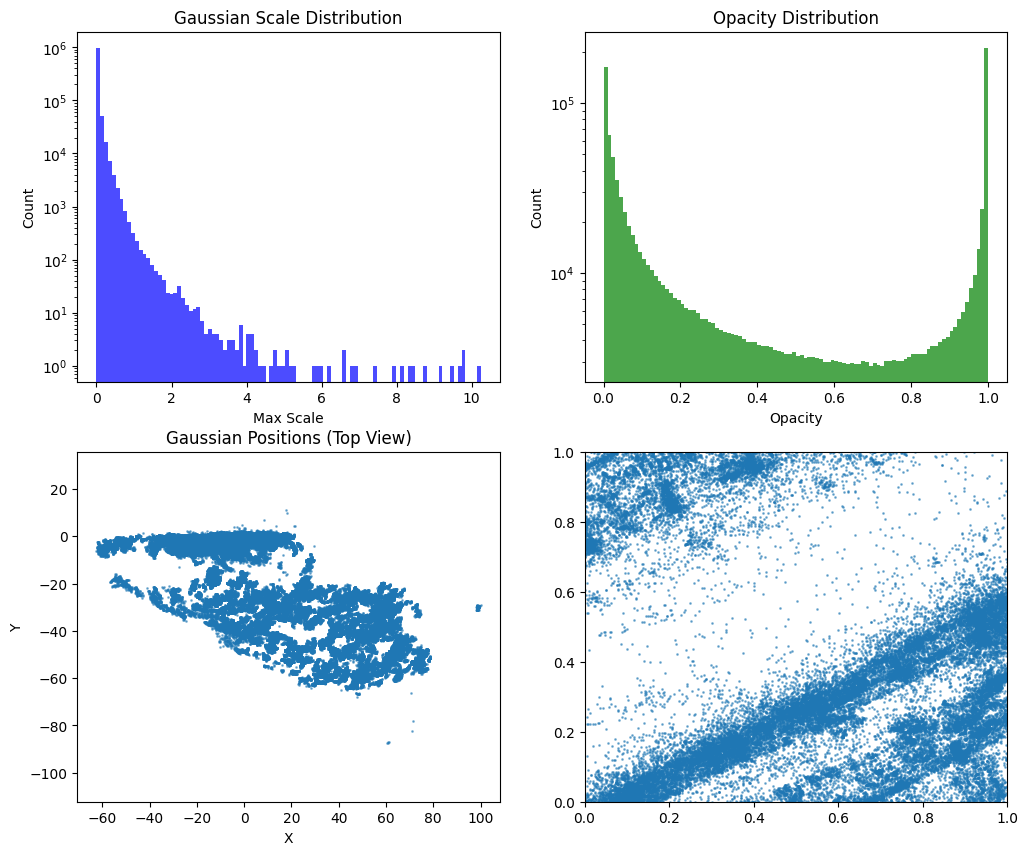

In [8]:
# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Scale histogram
axes[0, 0].hist(max_scale.numpy(), bins=100, alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Max Scale')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Gaussian Scale Distribution')
axes[0, 0].set_yscale('log')

# Opacity histogram
axes[0, 1].hist(opacities.squeeze().numpy(), bins=100, alpha=0.7, color='green')
axes[0, 1].set_xlabel('Opacity')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Opacity Distribution')
axes[0, 1].set_yscale('log')

# 3D positions
xyz = gaussians.get_xyz.detach().cpu().numpy()
axes[1, 0].scatter(xyz[:, 0], xyz[:, 1], s=1, alpha=0.5)
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Y')
axes[1, 0].set_title('Gaussian Positions (Top View)')
axes[1, 0].axis('equal')

axes[1, 1].scatter(xyz[:, 0], xyz[:, 2], s=1, alpha=0.5)
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Z')
axes[1, 1].set_title('Gaussian Positions (Side View)')
axes[1, 1].axis('equal')

plt.tight_layout()
plt.show()

print(f"\n📊 Visualization complete!")
print(f"Total Gaussians: {len(xyz)}")
print(f"Scene bounds:")
print(f"  X: [{xyz[:, 0].min():.3f}, {xyz[:, 0].max():.3f}]")
print(f"  Y: [{xyz[:, 1].min():.3f}, {xyz[:, 1].max():.3f}]")
print(f"  Z: [{xyz[:, 2].min():.3f}, {xyz[:, 2].max():.3f}]")

## Done!

You now have a fully functional Kaolin-based viewer for Gaussian Splatting scenes. 

### Next Steps:

- Experiment with different filter parameters
- Try different camera angles and positions
- Load different trained models
- Add custom rendering effects

### Troubleshooting:

- If rendering is slow, reduce the resolution in `render_kaolin()` and `selective_render_kaolin()`
- If the scene looks wrong, check that the camera coordinate system matches (Y-up vs Z-up)
- For CUDA out of memory errors, filter more Gaussians using the sliders